## Python Integration of myeloid cells 
* In the notebook will perform QC-->Integration steps following by clustering and annotation iteratively. 
* Essentially here I perform initial QC and integration on the merged object (NR_data_intersect.h5ad), I then perform clustering and exclude contaminating cells. On the remaining cells I then repeat QC-->integration steps from finidng variable genes onwards and then repeat clustering. I do this iteratively until all contaminating cells are removed and all remaining cells are annotated
* note I don't need to repeat regressing the cycling genes every iteration just in the initial QC

### Notes on the object
* I am using the intersect object and not the 'all' genes object as majority of the 'extra' genes in the all genes object are unknown, ncRNA, uncharacterised, or pseudogenes. Also by including genes only present in some datasets I worry this will cause batch specific clustering

## Set up workspace and import initial data:

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce

In [2]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

Print software versions:

In [3]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


Set plotting parameters

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [6]:
#read in the file
data = sc.read_h5ad('/scratch/user/s4436039/scdata/Myeloid_Objects/NR_data_intersect.h5ad')

In [7]:
data

AnnData object with n_obs × n_vars = 623908 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id'
    var: 'name'

In [8]:
#remove PCA and UMAP data done previously
# Remove PCA results
if 'X_pca' in data.obsm:
    del data.obsm['X_pca']
if 'pca' in data.uns:
    del data.uns['pca']
if 'PCs' in data.varm:
    del data.varm['PCs']

# Remove UMAP results
if 'X_umap' in data.obsm:
    del data.obsm['X_umap']
if 'umap' in data.uns:
    del data.uns['umap']

In [9]:
data

AnnData object with n_obs × n_vars = 623908 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id'
    var: 'name'

In [10]:
data.obs

nCount_RNA  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                    20298.000000   
GSE215120_AM1_AAAGATGTCCAAATGC-1                     5574.000000   
GSE215120_AM1_AAAGTAGTCGGTGTTA-1                    13432.000000   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                    17143.000000   
GSE215120_AM1_AAATGCCGTTTGGCGC-1                     3603.000000   
...                                                          ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.871771   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.766977   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.133310   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -9.313746   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -4.476278   

                                                    nFeature_RNA sample_type  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                     3789.000000      tumour   
GSE215120_AM1_AAAGATGTCCAAATGC-1                     1721.000000      tumour   
GSE215120_AM1_AAAGTAGTCGGTGTTA-1                     2759.000000      tumour   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                     2659.000000      tumour   
GSE215120_AM1_AAATGCCGTTTGGCGC-1                     1012.000000      tumour   
...                                                          ...         ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    -10.337130      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -8.292435      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -8.758132      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...     -7.889039      Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...    -10.355681      Adnexa   

                                                       cancer_type  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                    Acral Melanoma   
GSE215120_AM1_AAAGATGTCCAAATGC-1                    Acral Melanoma   
GSE215120_AM1_AAAGTAGTCGGTGTTA-1                    Acral Melanoma   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                    Acral Melanoma   
GSE215120_AM1_AAATGCCGTTTGGCGC-1                    Acral Melanoma   
...                                                            ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...           HGSOC   

                                                     patient_id  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                            AM1   
GSE215120_AM1_AAAGATGTCCAAATGC-1                            AM1   
GSE215120_AM1_AAAGTAGTCGGTGTTA-1                            AM1   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                            AM1   
GSE215120_AM1_AAATGCCGTTTGGCGC-1                            AM1   
...                                                         ...   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_O...  Left Adnexa   

                                                                              sample_id  \
GSE215120_AM1_AAACCTGGTTGCTCCT-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAAGATGTCCAAATGC-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAAGTAGTCGGTGTTA-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAATGCCCAGAGCCAA-1                                GSE215120_Acral_MEL_AM1   
GSE215120_AM1_AAATGCCGTTTGGCGC-1                                GSE215120_Acral_MEL_AM1   
...                                                                                 

In [11]:
data.var

name
FAM87B        FAM87B
LINC00115  LINC00115
FAM41C        FAM41C
SAMD11        SAMD11
NOC2L          NOC2L
...              ...
MT-ND4L      MT-ND4L
MT-ND4        MT-ND4
MT-ND5        MT-ND5
MT-ND6        MT-ND6
MT-CYB        MT-CYB

[15074 rows x 1 columns]

In [12]:
#tabulate number of cells per sample type/ site/ cancer type and export as csv
table1 = pd.crosstab(data.obs["dataset_id"], data.obs["cancer_subtype"])
table2 = pd.crosstab(data.obs["cancer_subtype"], data.obs["sample_type_major"])
table3 = pd.crosstab(data.obs["site"], data.obs["sample_type_major"])
table4 = pd.crosstab(data.obs["cancer_subtype"], data.obs["site"])


table1.to_csv('table_dataset-v-cancer_subtype.csv')
table2.to_csv('table_cancer_subtype-v-sample_type.csv')
table3.to_csv('table_site-v-sample_type.csv')
table4.to_csv('table_cancer_subtype-v-site.csv')

## Perform QC Steps on initial object:

In [13]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
data.var["mt"] = data.var_names.str.startswith("MT-")

In [14]:
#calculate QC metrics
sc.pp.calculate_qc_metrics(
    data, qc_vars=["mt"], inplace=True, log1p=True
)

In [15]:
data.obs.columns.tolist()

['nCount_RNA',
 'nFeature_RNA',
 'sample_type',
 'cancer_type',
 'patient_id',
 'sample_id',
 'percent.mt',
 'site',
 'sample_type_major',
 'cancer_subtype',
 'integration_id',
 'ident',
 'dataset_id',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt']

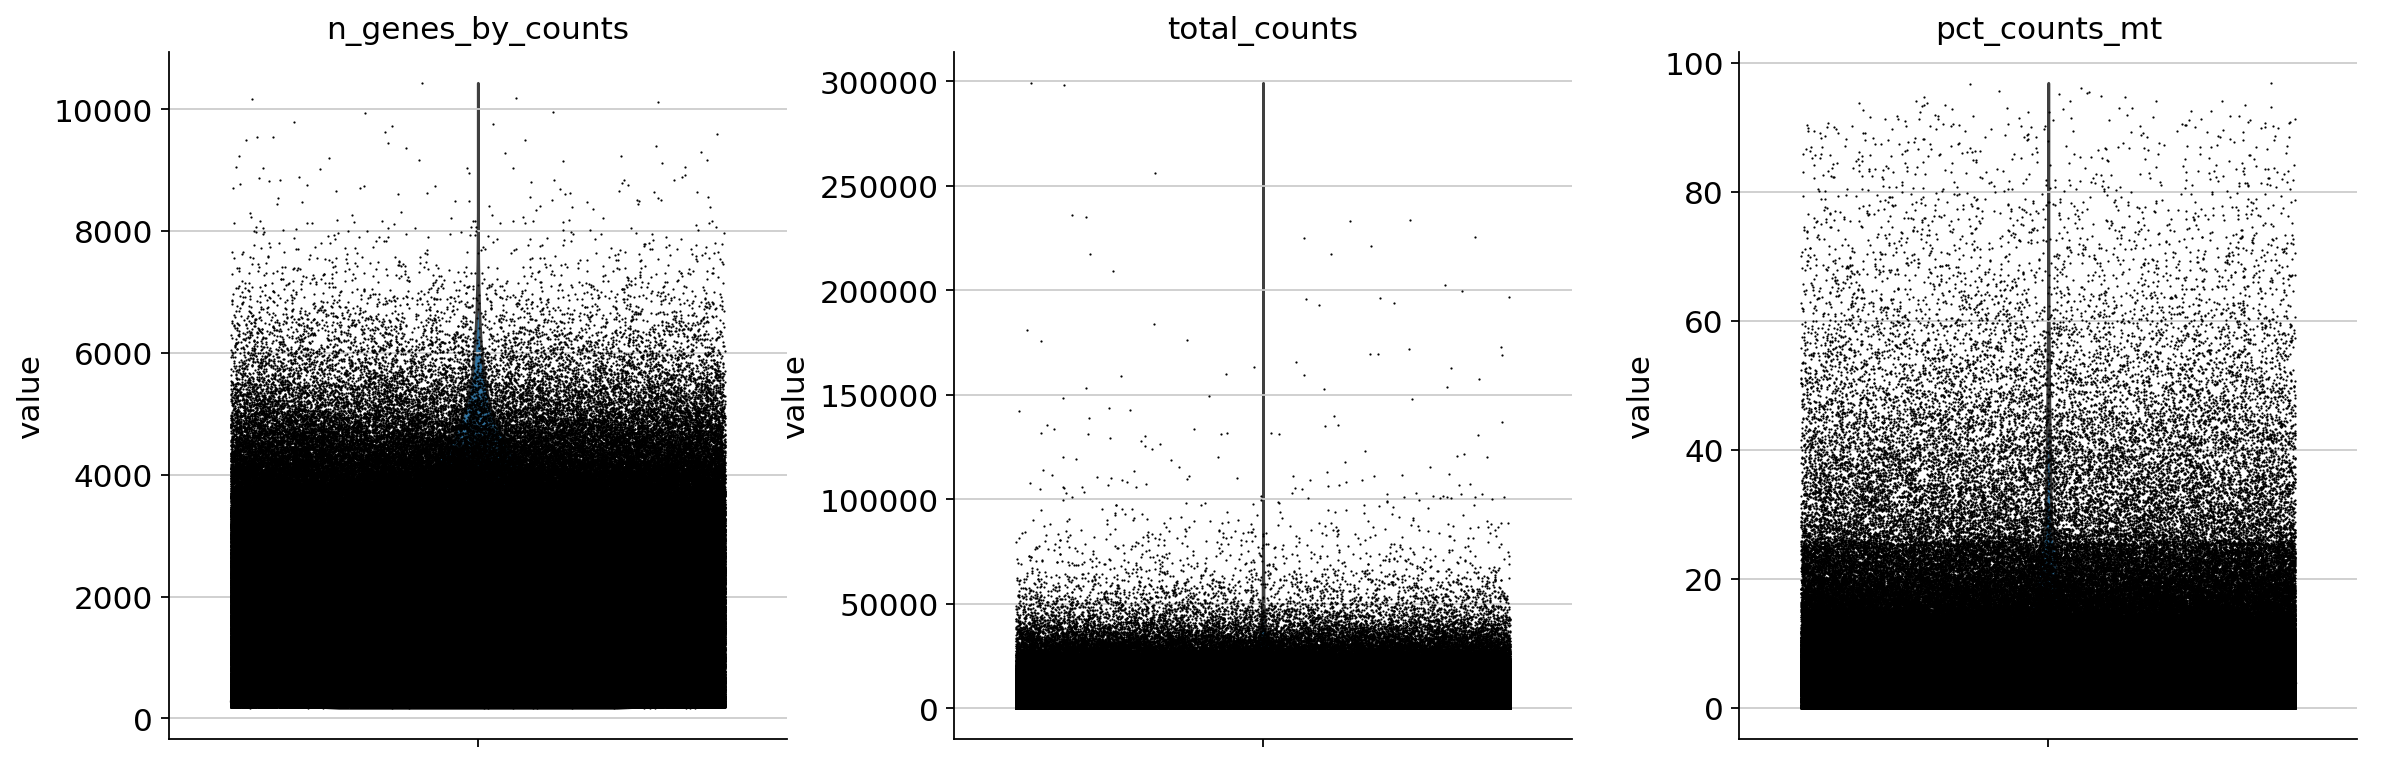

In [16]:
#plot metrics
sc.pl.violin(
    data,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

### Calculate cycling scores:
* following the method described here: https://notebook.community/theislab/scanpy_usage/180209_cell_cycle/cell_cycle

In [24]:
#load cell cycle genes previously defined in literature (Tirosh et al 2015)
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]

In [25]:
# define two lists, genes associated to the S phase and genes associated to the G2M phase
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in data.var_names]

### Normalise data:

In [19]:
sc.pp.normalize_total(data, target_sum=1e4)

# Logarithmize the data:
sc.pp.log1p(data)

# check the object
data

AnnData object with n_obs × n_vars = 623908 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

### save a version of the object here that will be used for WGCNA (after log transform but before scaling), will then need to feed the metadata (cell annotations) into this object once I have those 

In [20]:
#write out the object for WGCNA (7min)
data.write_h5ad("NRdata_for-WGCNA_no-meta.h5ad", compression="gzip")

### Identify highly variable genes:

In [13]:
data = sc.read_h5ad("NRdata_for-WGCNA_no-meta.h5ad")
data

AnnData object with n_obs × n_vars = 623908 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [14]:
# (Expects logarithimised data)
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
data

AnnData object with n_obs × n_vars = 623908 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [15]:
#set hidden slot
data.raw = data

In [16]:
# to see genes
data.var  # there is now a hvg column

name     mt  n_cells_by_counts  mean_counts  \
FAM87B        FAM87B  False               1593     0.002608   
LINC00115  LINC00115  False              13748     0.023226   
FAM41C        FAM41C  False              10546     0.017495   
SAMD11        SAMD11  False                949     0.001802   
NOC2L          NOC2L  False             103531     0.211007   
...              ...    ...                ...          ...   
MT-ND4L      MT-ND4L   True             459268     6.269149   
MT-ND4        MT-ND4   True             588421    47.422801   
MT-ND5        MT-ND5   True             544183    12.252872   
MT-ND6        MT-ND6   True             268365     1.325729   
MT-CYB        MT-CYB   True             584920    38.210757   

           log1p_mean_counts  pct_dropout_by_counts  total_counts  \
FAM87B              0.002604              99.744674        1627.0   
LINC00115           0.022961              97.796470       14491.0   
FAM41C              0.017343              98.309687       10915.0   
SAMD11              0.001800              99.847894        1124.0   
NOC2L               0.191452              83.406047      131649.0   
...                      ...                    ...           ...   
MT-ND4L             1.983639              26.388506     3911372.0   
MT-ND4              3.879971               5.687858    29587465.0   
MT-ND5              2.584214              12.778326     7644665.0   
MT-ND6              0.844034              56.986447      827133.0   
MT-CYB              3.668951               6.248998    23839997.0   

           log1p_total_counts  highly_variable     means  dispersions  \
FAM87B               7.395108            False  0.003131     1.017997   
LINC00115            9.581352            False  0.033554     1.597652   
FAM41C               9.297985            False  0.022248     1.542000   
SAMD11               7.025538            False  0.002381     1.669414   
NOC2L               11.787902            False  0.233704     1.515548   
...                       ...              ...       ...          ...   
MT-ND4L             15.179399             True  2.498015     4.540784   
MT-ND4              17.202861            False  4.173388     4.378180   
MT-ND5              15.849519             True  2.894607     3.346545   
MT-ND6              13.625722             True  1.132630     3.572825   
MT-CYB              16.986875            False  3.997174     4.436170   

           dispersions_norm  
FAM87B            -1.808694  
LINC00115         -0.425234  
FAM41C            -0.558058  
SAMD11            -0.253960  
NOC2L             -0.621190  
...                     ...  
MT-ND4L            1.878395  
MT-ND4             0.304262  
MT-ND5             0.625154  
MT-ND6             4.222325  
MT-CYB             0.491209  

[15074 rows x 12 columns]

In [17]:
#to get number of HV genes (because the column "highly_variable" is a boolean vector - ie it gives True (1) or False (0), you can use sum function to know)
print(data.var.highly_variable.sum())

1634


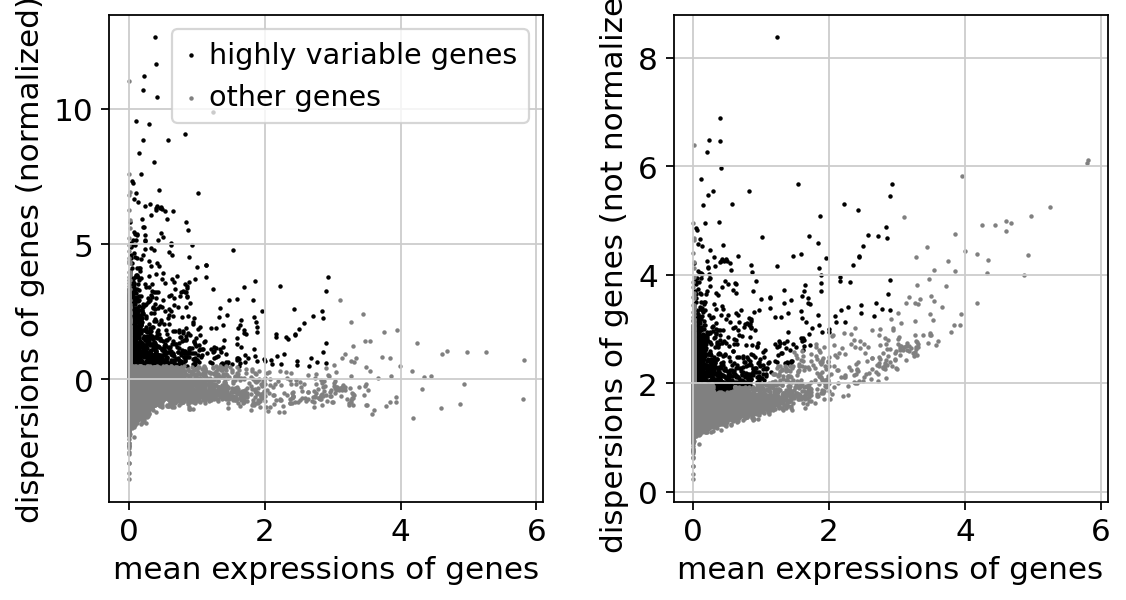

In [18]:
#plot out the number of highly variable genes
sc.pl.highly_variable_genes(data)

### Perform dimensionality reduction and scaling:

In [19]:
# Actually do the filtering for PCA
data = data[
    :, data.var.highly_variable
].copy()  # all rows/indexes : columns only selecting for those within high_variable, and then making a copy of itself
data

AnnData object with n_obs × n_vars = 623908 × 1634
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [20]:
data1 = data.copy()

In [21]:
#regress out effects of total_counts per cell and % of mt genes (~9min)
sc.pp.regress_out(data1, ["total_counts", "pct_counts_mt"])

In [22]:
# Scale each gene to unit variance. Clip values exceeding std of 10.
sc.pp.scale(data1, max_value=10)

### After scaling now regress out cycling genes and re-scale

In [26]:
#cell cycle scoring, this adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.
sc.tl.score_genes_cell_cycle(data1, s_genes=s_genes, g2m_genes=g2m_genes)

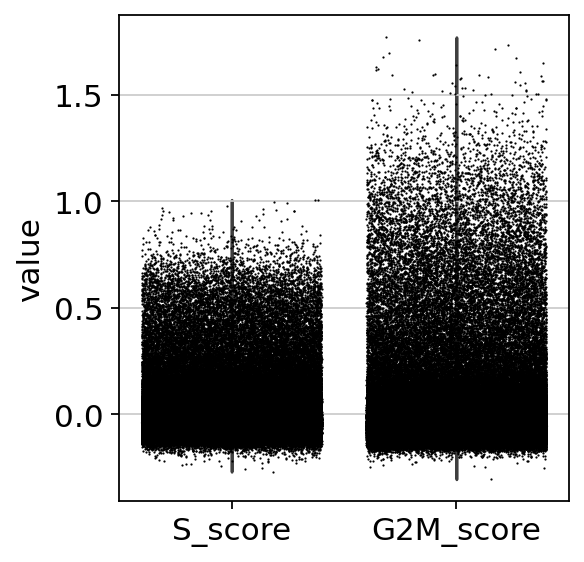

In [27]:
sc.pl.violin(data1, ['S_score', 'G2M_score'],
             jitter=0.4)

In [28]:
data.obs["S_score"] = data1.obs["S_score"]
data.obs["G2M_score"] = data1.obs["G2M_score"]

In [29]:
pre_hvg_data = sc.read_h5ad("NRdata_for-WGCNA_no-meta.h5ad")
pre_hvg_data.obs["S_score"] = data1.obs["S_score"]
pre_hvg_data.obs["G2M_score"] = data1.obs["G2M_score"]
pre_hvg_data
pre_hvg_data.write_h5ad("NRdata_for-WGCNA_no-meta.h5ad", compression = "gzip")

In [31]:
#Regress out cycling genes (9min)
sc.pp.regress_out(data, ["total_counts", "pct_counts_mt", 'S_score', 'G2M_score'])
sc.pp.scale(data, max_value=10)

In [32]:
data

AnnData object with n_obs × n_vars = 623908 × 1634
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [50]:
#gene_of_interest = 'MCM5'  

# Check if the gene is in the .var index
#if gene_of_interest in data.var_names:
#    print(f"{gene_of_interest} is present in the dataset.")
#else:
#    print(f"{gene_of_interest} is not present in the dataset.")

MCM5 is not present in the dataset.


### Perform PCA: 

* note originally I tried increases the number of PCs a lot (>100) but this made the integration later on converge really fast and then not be well integrated, likely because increasing PCs too much can increase noise or lead to overfitting of batch effects, therefore decreased to 60

In [33]:
## perform PCA, adjust number of PCs to calculate from default (50) to 60. (3mins)
sc.tl.pca(data, n_comps=60)

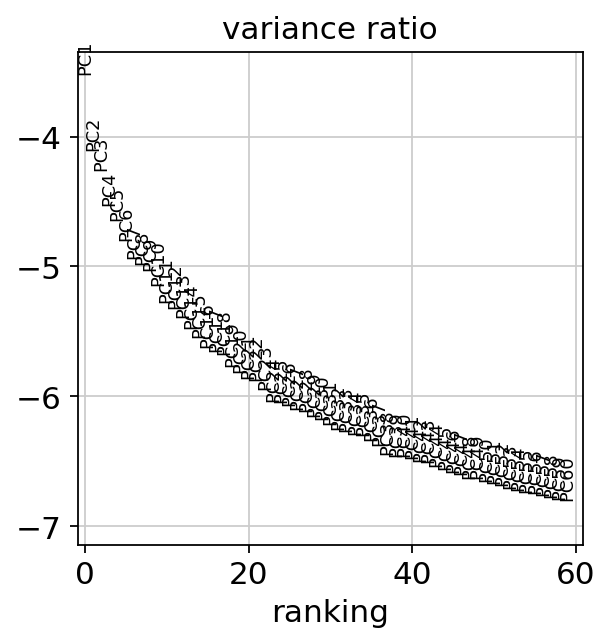

In [35]:
# make elbow plot to see variance contribution by each pc, choose inflection point
sc.pl.pca_variance_ratio(data, log=True, n_pcs=60)

#based on graph choose to use 60 PCs going forward

### Export out the object that will be used for integration:

In [36]:
#at this point export out the object as the one we will use for integration (11min)
data.write_h5ad("NRdata_pre-int.h5ad", compression="gzip")

In [6]:
#read in the file
#data = sc.read_h5ad('NRdata_pre-int.h5ad')

### Perform neigborhood and UMAP on unintegrated data as a comparison:

### Neighborhood graph:

In [37]:
## Computing neighbourhood graph - here UMAP (3min)
sc.pp.neighbors(data, n_neighbors=10, n_pcs=60)

### UMAP (~16min):

In [38]:
#Embedding the neighbourhood graph using UMAP 
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

### UMAP Visualisation:

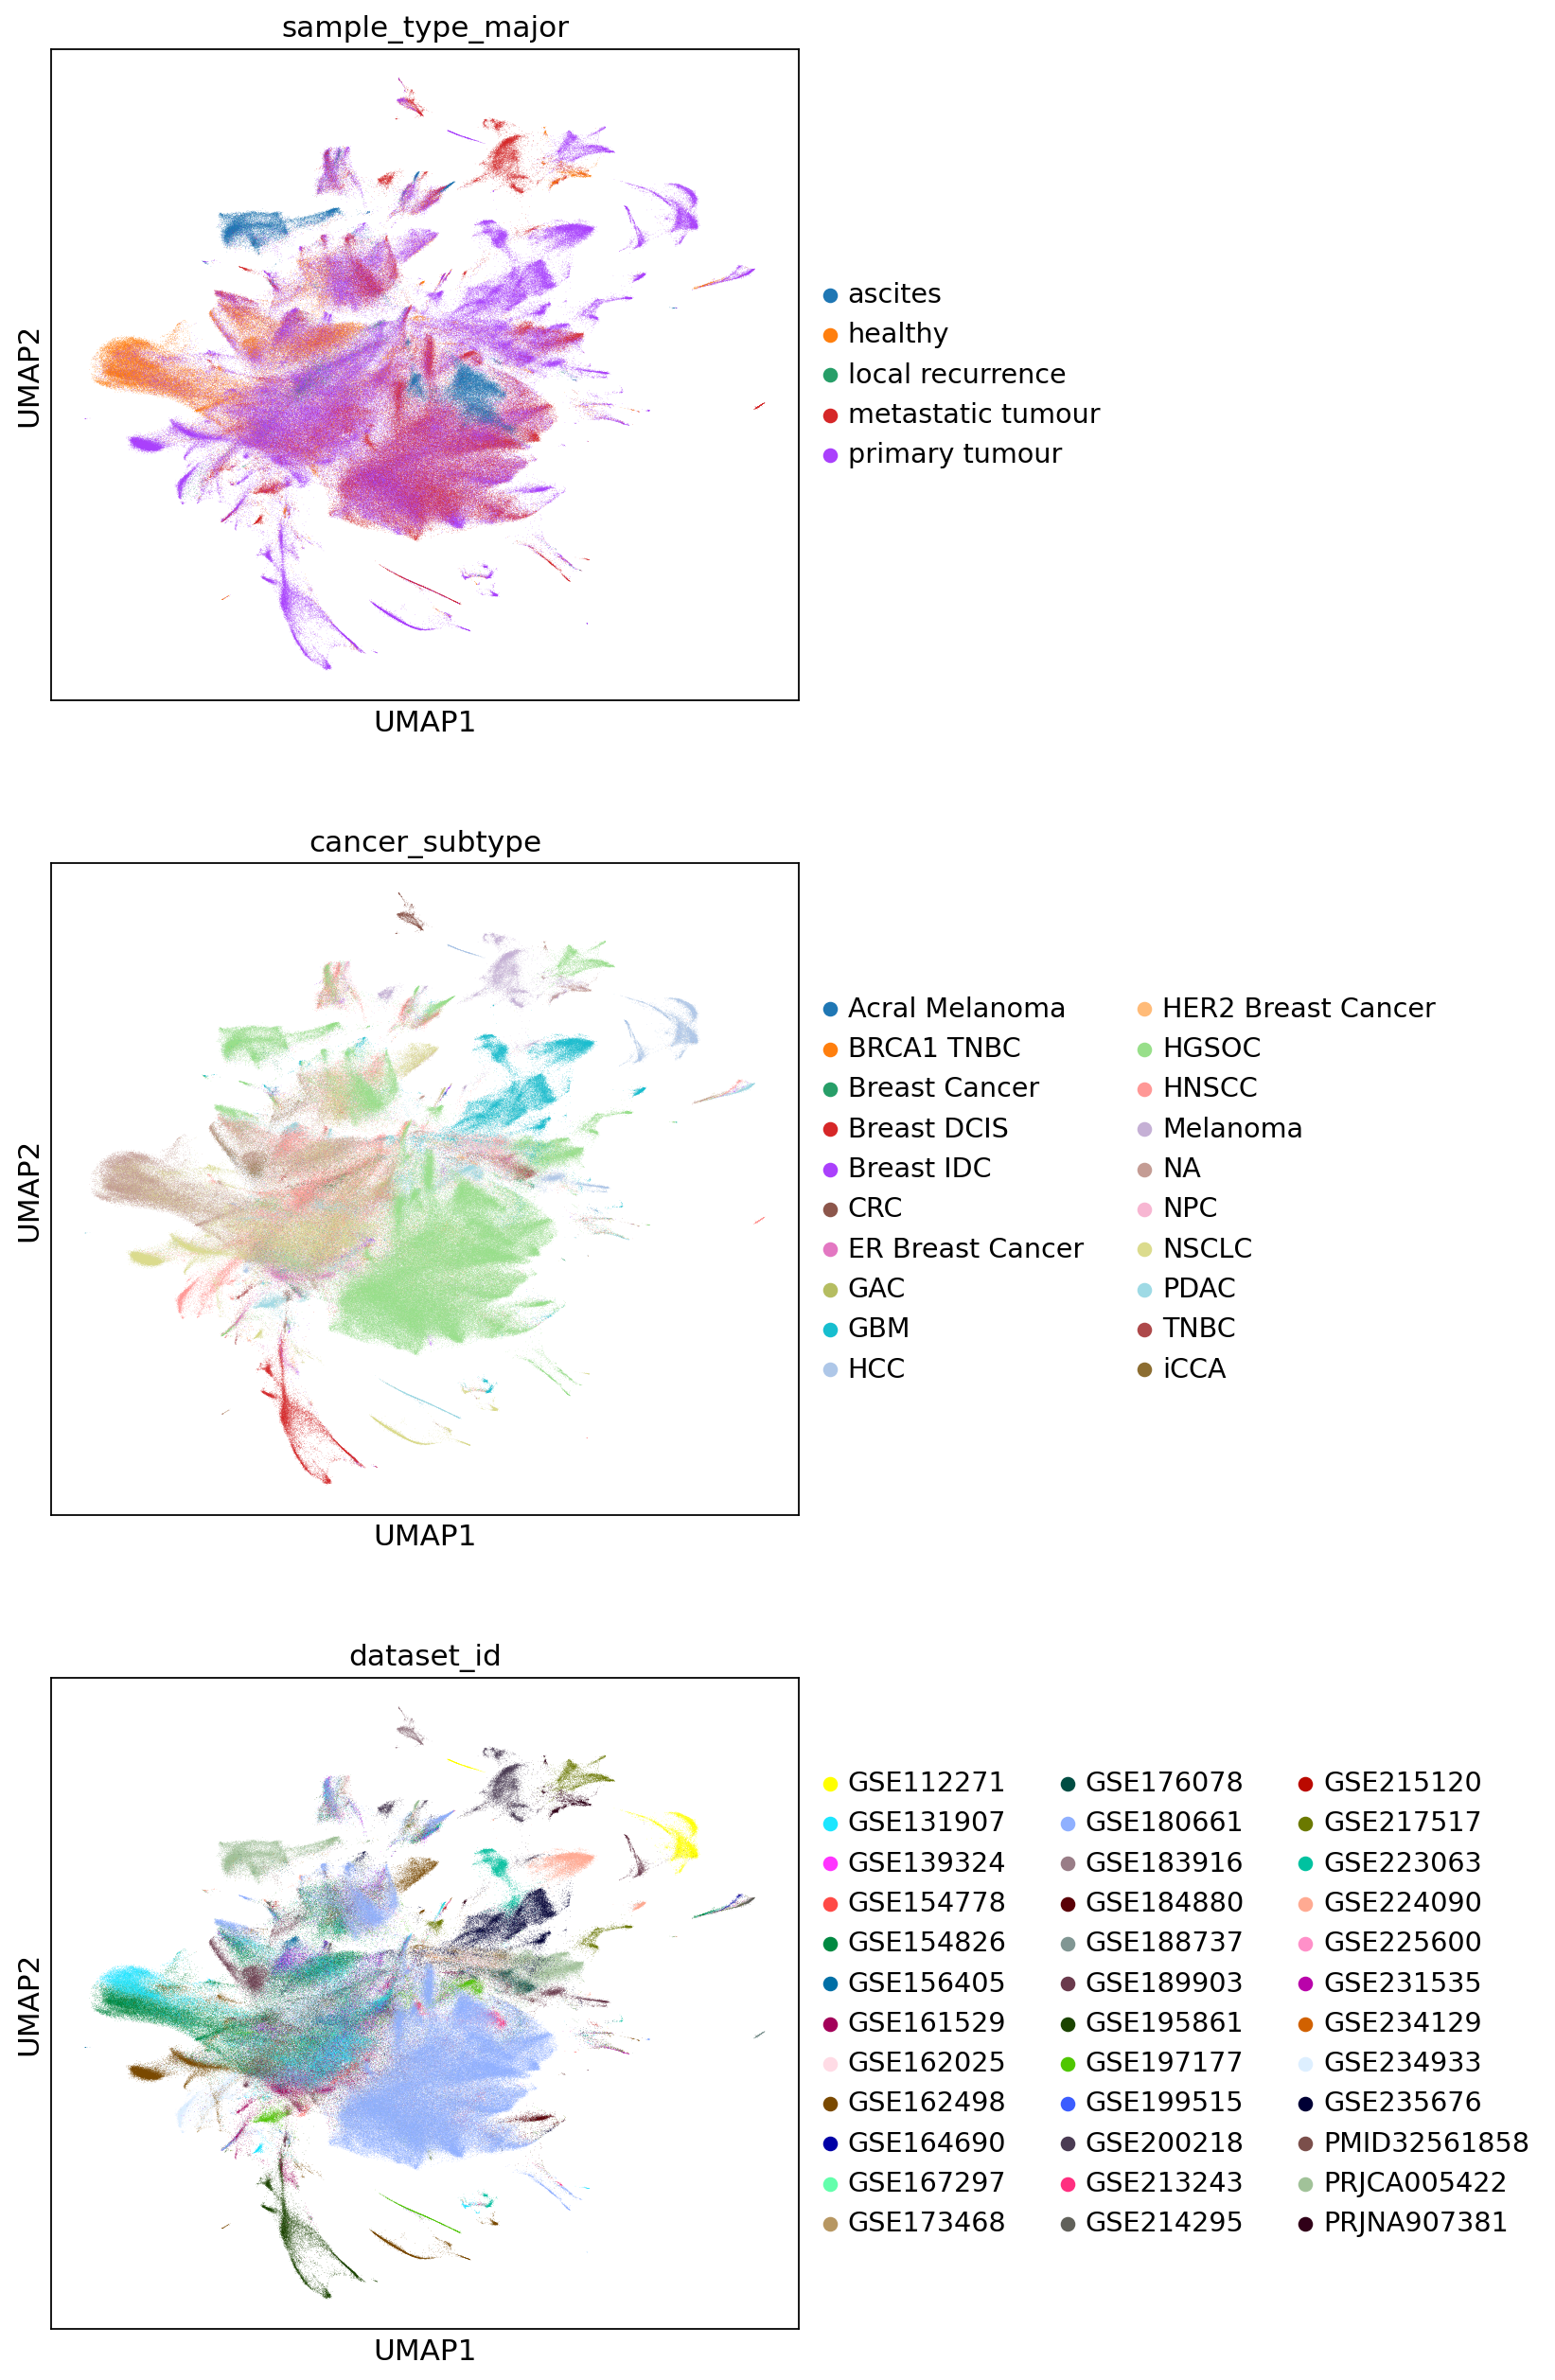

In [39]:
#visualise UMAP
with plt.rc_context({"figure.figsize": (6, 6)}):
    sc.pl.umap(
        data,
        color=[
            "sample_type_major",
            "cancer_subtype",
            "dataset_id",
        ],
        ncols=1,
    )

In [40]:
#write out the unintegrated object to be read in later if needed (12min)
data.write_h5ad("NRdata_unintegrated.h5ad", compression="gzip")

## Integration: 
#### want to perform integration after running PCA but before computing neighbor graph (perform on NRdata_pre-int.h5ad)

### Integration step was done by submitting a job. 

* Bashscript is named: 2024-09-10_bashscript-NR-int.sh
* python script named: 2024-09-10_NR-Integration-script.py

Ran with `sbatch 2024-09-10_bashscript-NR-int.sh`

Bashscript: 
``` bash
#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=64
#SBATCH --mem=400G
#SBATCH --job-name=NR-Integration
#SBATCH --time=18:00:00
#SBATCH --partition=general
#SBATCH --account=a_kelvin_tuong
#SBATCH -o NR-Integration.output
#SBATCH -e NR-Integration.error

# export JAVA_CMD=/home/uqztuong/miniforge3/bin/java
source ~/.bashrc
mamba activate env
python3 2024-09-10_NR-Integration-script.py
```

Python script: 
``` python
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce

os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')

data_pre = sc.read_h5ad('/scratch/user/s4436039/scdata/Python_Integration_Sep/NRdata_pre-int.h5ad')

sce.pp.harmony_integrate(data_pre, 'integration_id', max_iter_harmony=200, verbose=True)

data_pre.write_h5ad("/scratch/user/s4436039/scdata/Python_Integration_Sep/NRdata_post-int.h5ad", compression="gzip")
```

### Converged after 9 iterations

### Read in data after integration:

In [6]:
#read in after integration
data = sc.read_h5ad('NRdata_post-int.h5ad')

In [7]:
data.obsm

AxisArrays with keys: X_pca, X_pca_harmony

In [8]:
#check it made new column with adjusted harmony PCs
'X_pca_harmony' in data.obsm

True

In [9]:
#assign the new PCs to the standard PCA slot
data.obsm['X_pca'] = data.obsm['X_pca_harmony']

### Neighborhood graph:

In [10]:
## Computing neighbourhood graph - here UMAP
sc.pp.neighbors(data, n_neighbors=10, n_pcs=60)

### UMAP (~15min):

In [11]:
sc.tl.umap(data, min_dist=0.3)  # 0.3 is personal preference

### UMAP Visualisation:

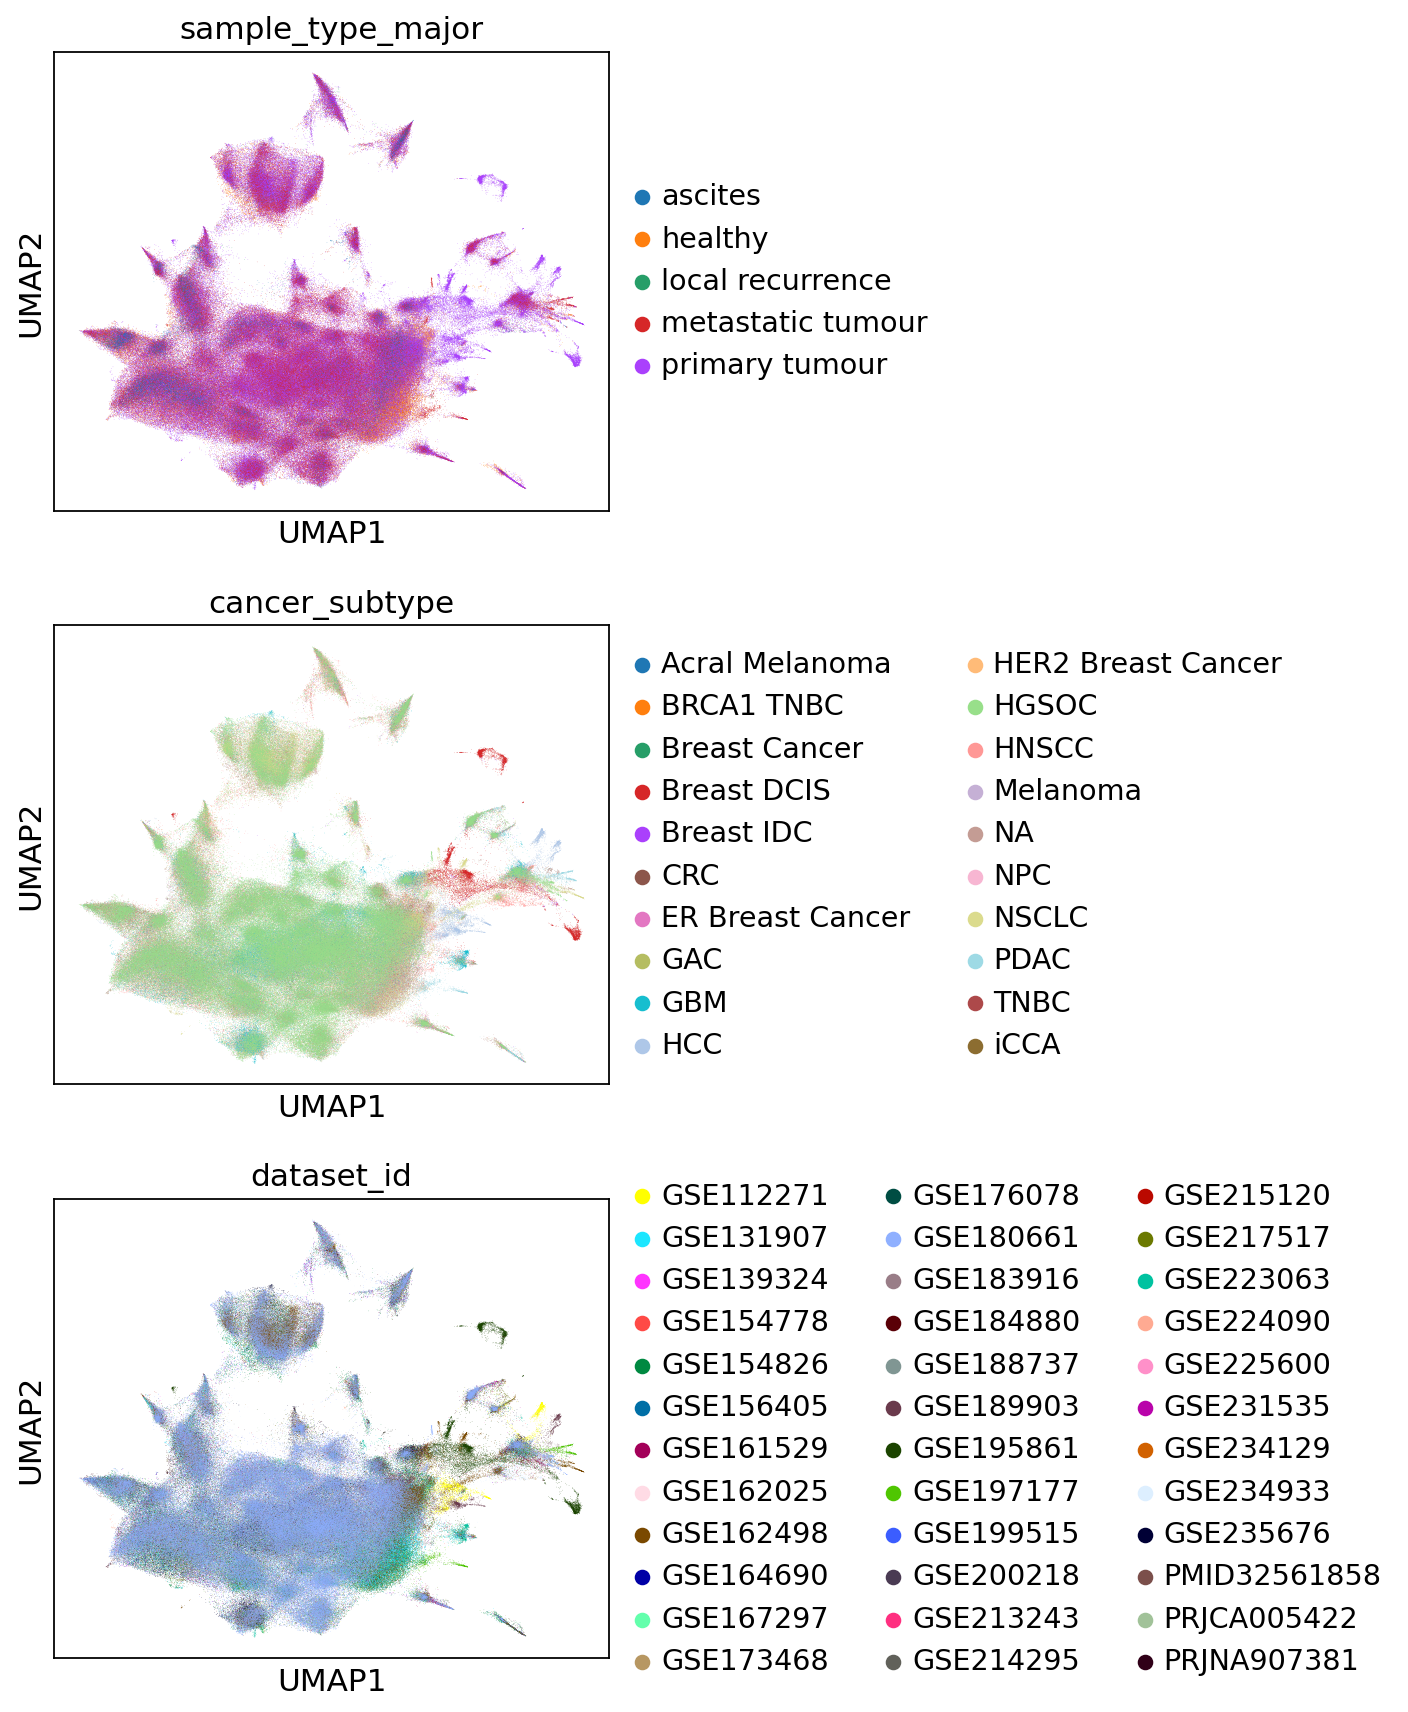

In [12]:
#same as above 
#visualise UMAP --> can see now integrated
sc.pl.umap(
    data,
    color=[
        "sample_type_major",
        "cancer_subtype",
        "dataset_id",
    ],
    ncols=1,
)

In [13]:
#split plot by sample_type_major, cancer_subtype etc

#define function
def cluster_small_multiples(
    data_int, clust_key, size=30, frameon=False, legend_loc=None, **kwargs
):
    tmp = data_int.copy()

    for i, clust in enumerate(data_int.obs[clust_key].cat.categories):
        tmp.obs[clust] = data_int.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", data_int.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=data_int.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc,
        **kwargs
    )

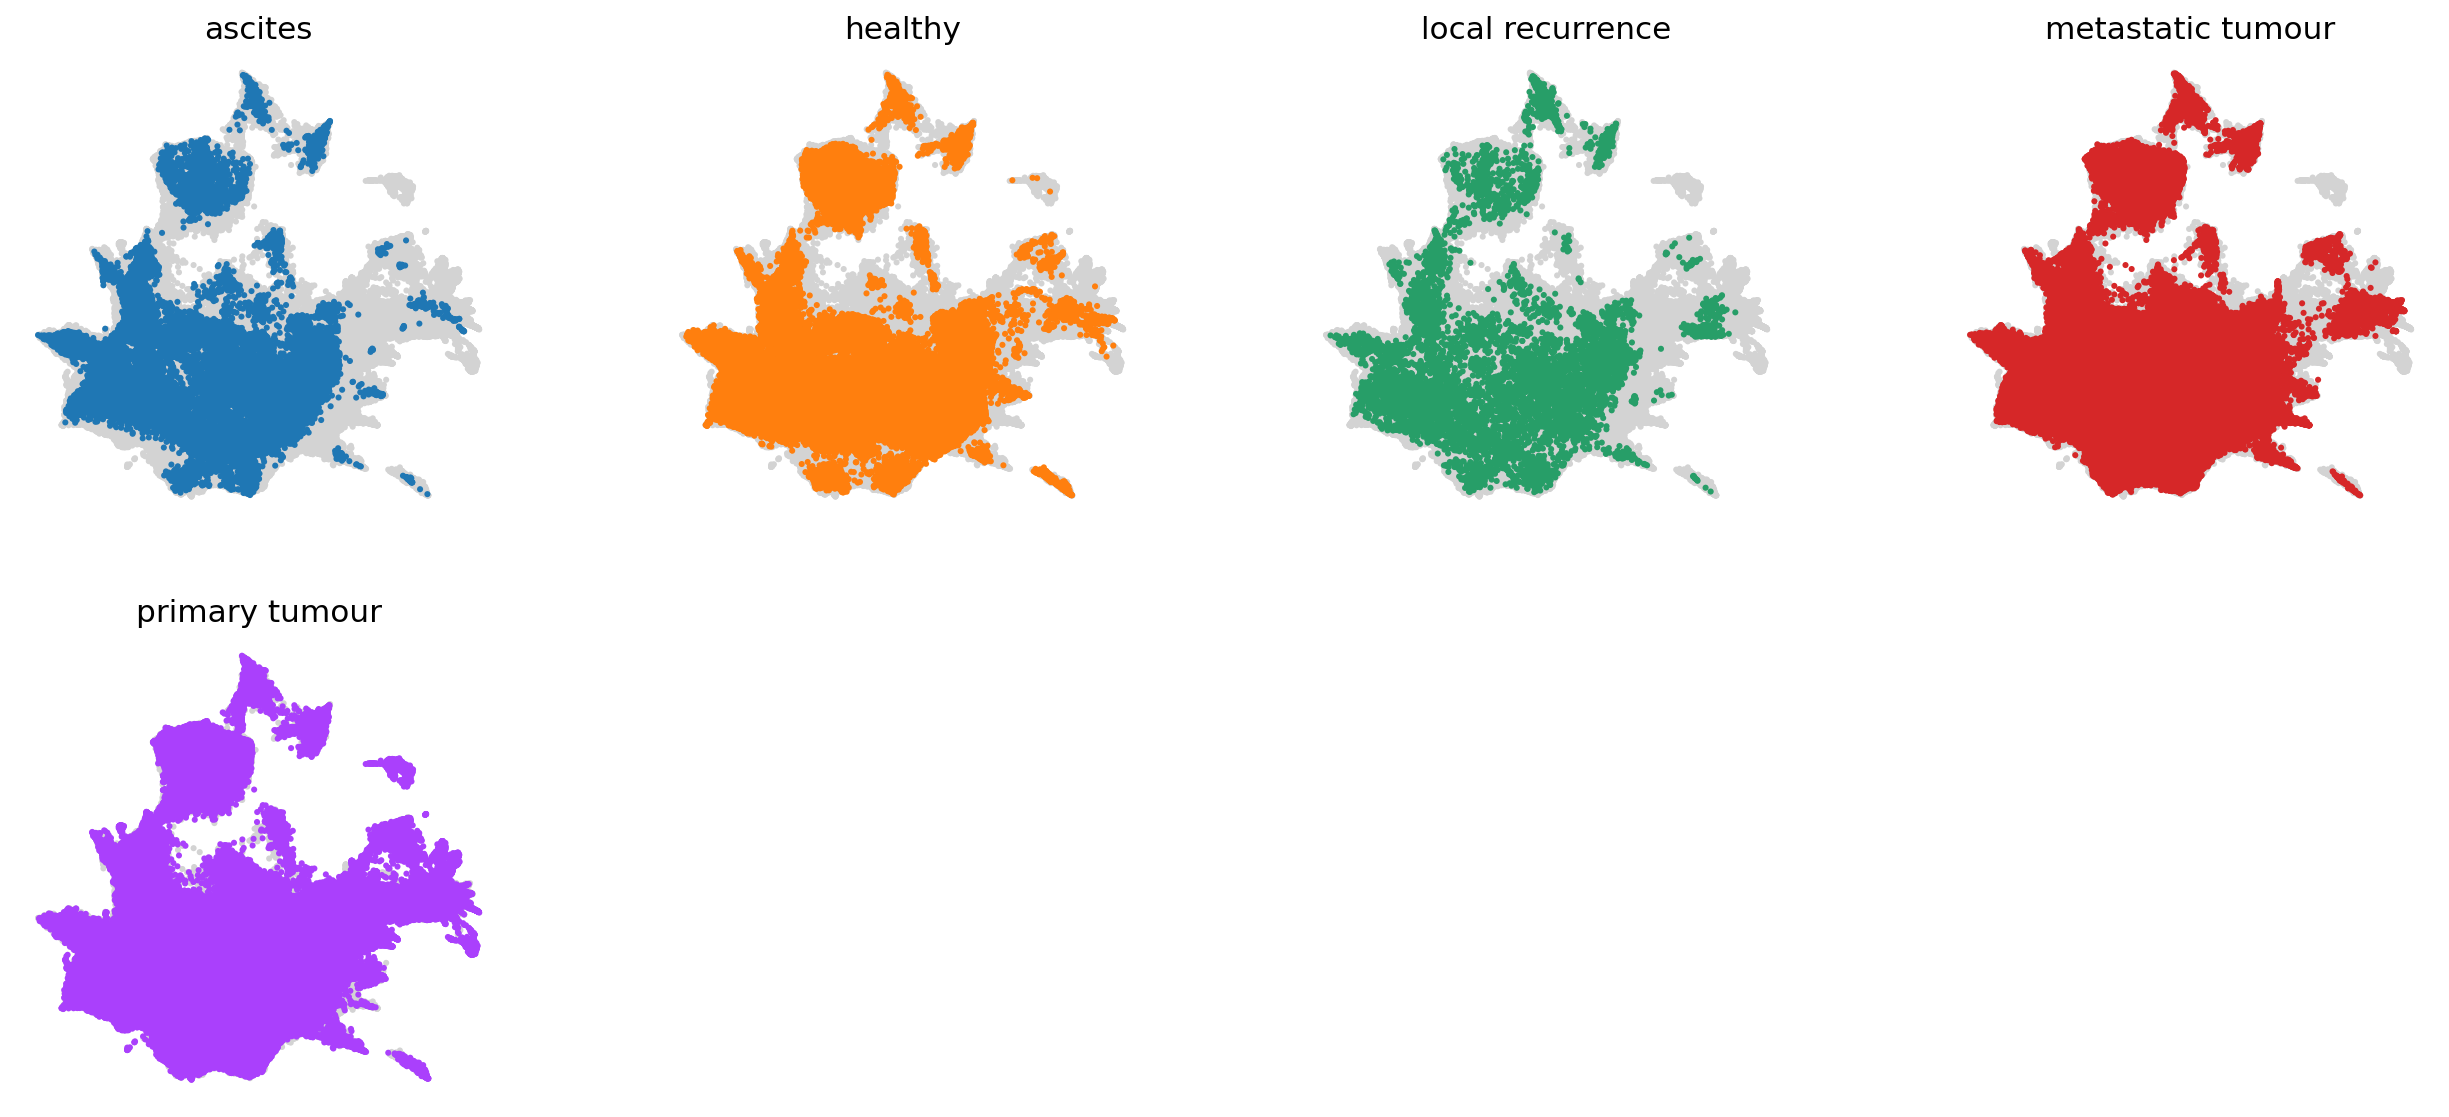

In [14]:
cluster_small_multiples(data, "sample_type_major")

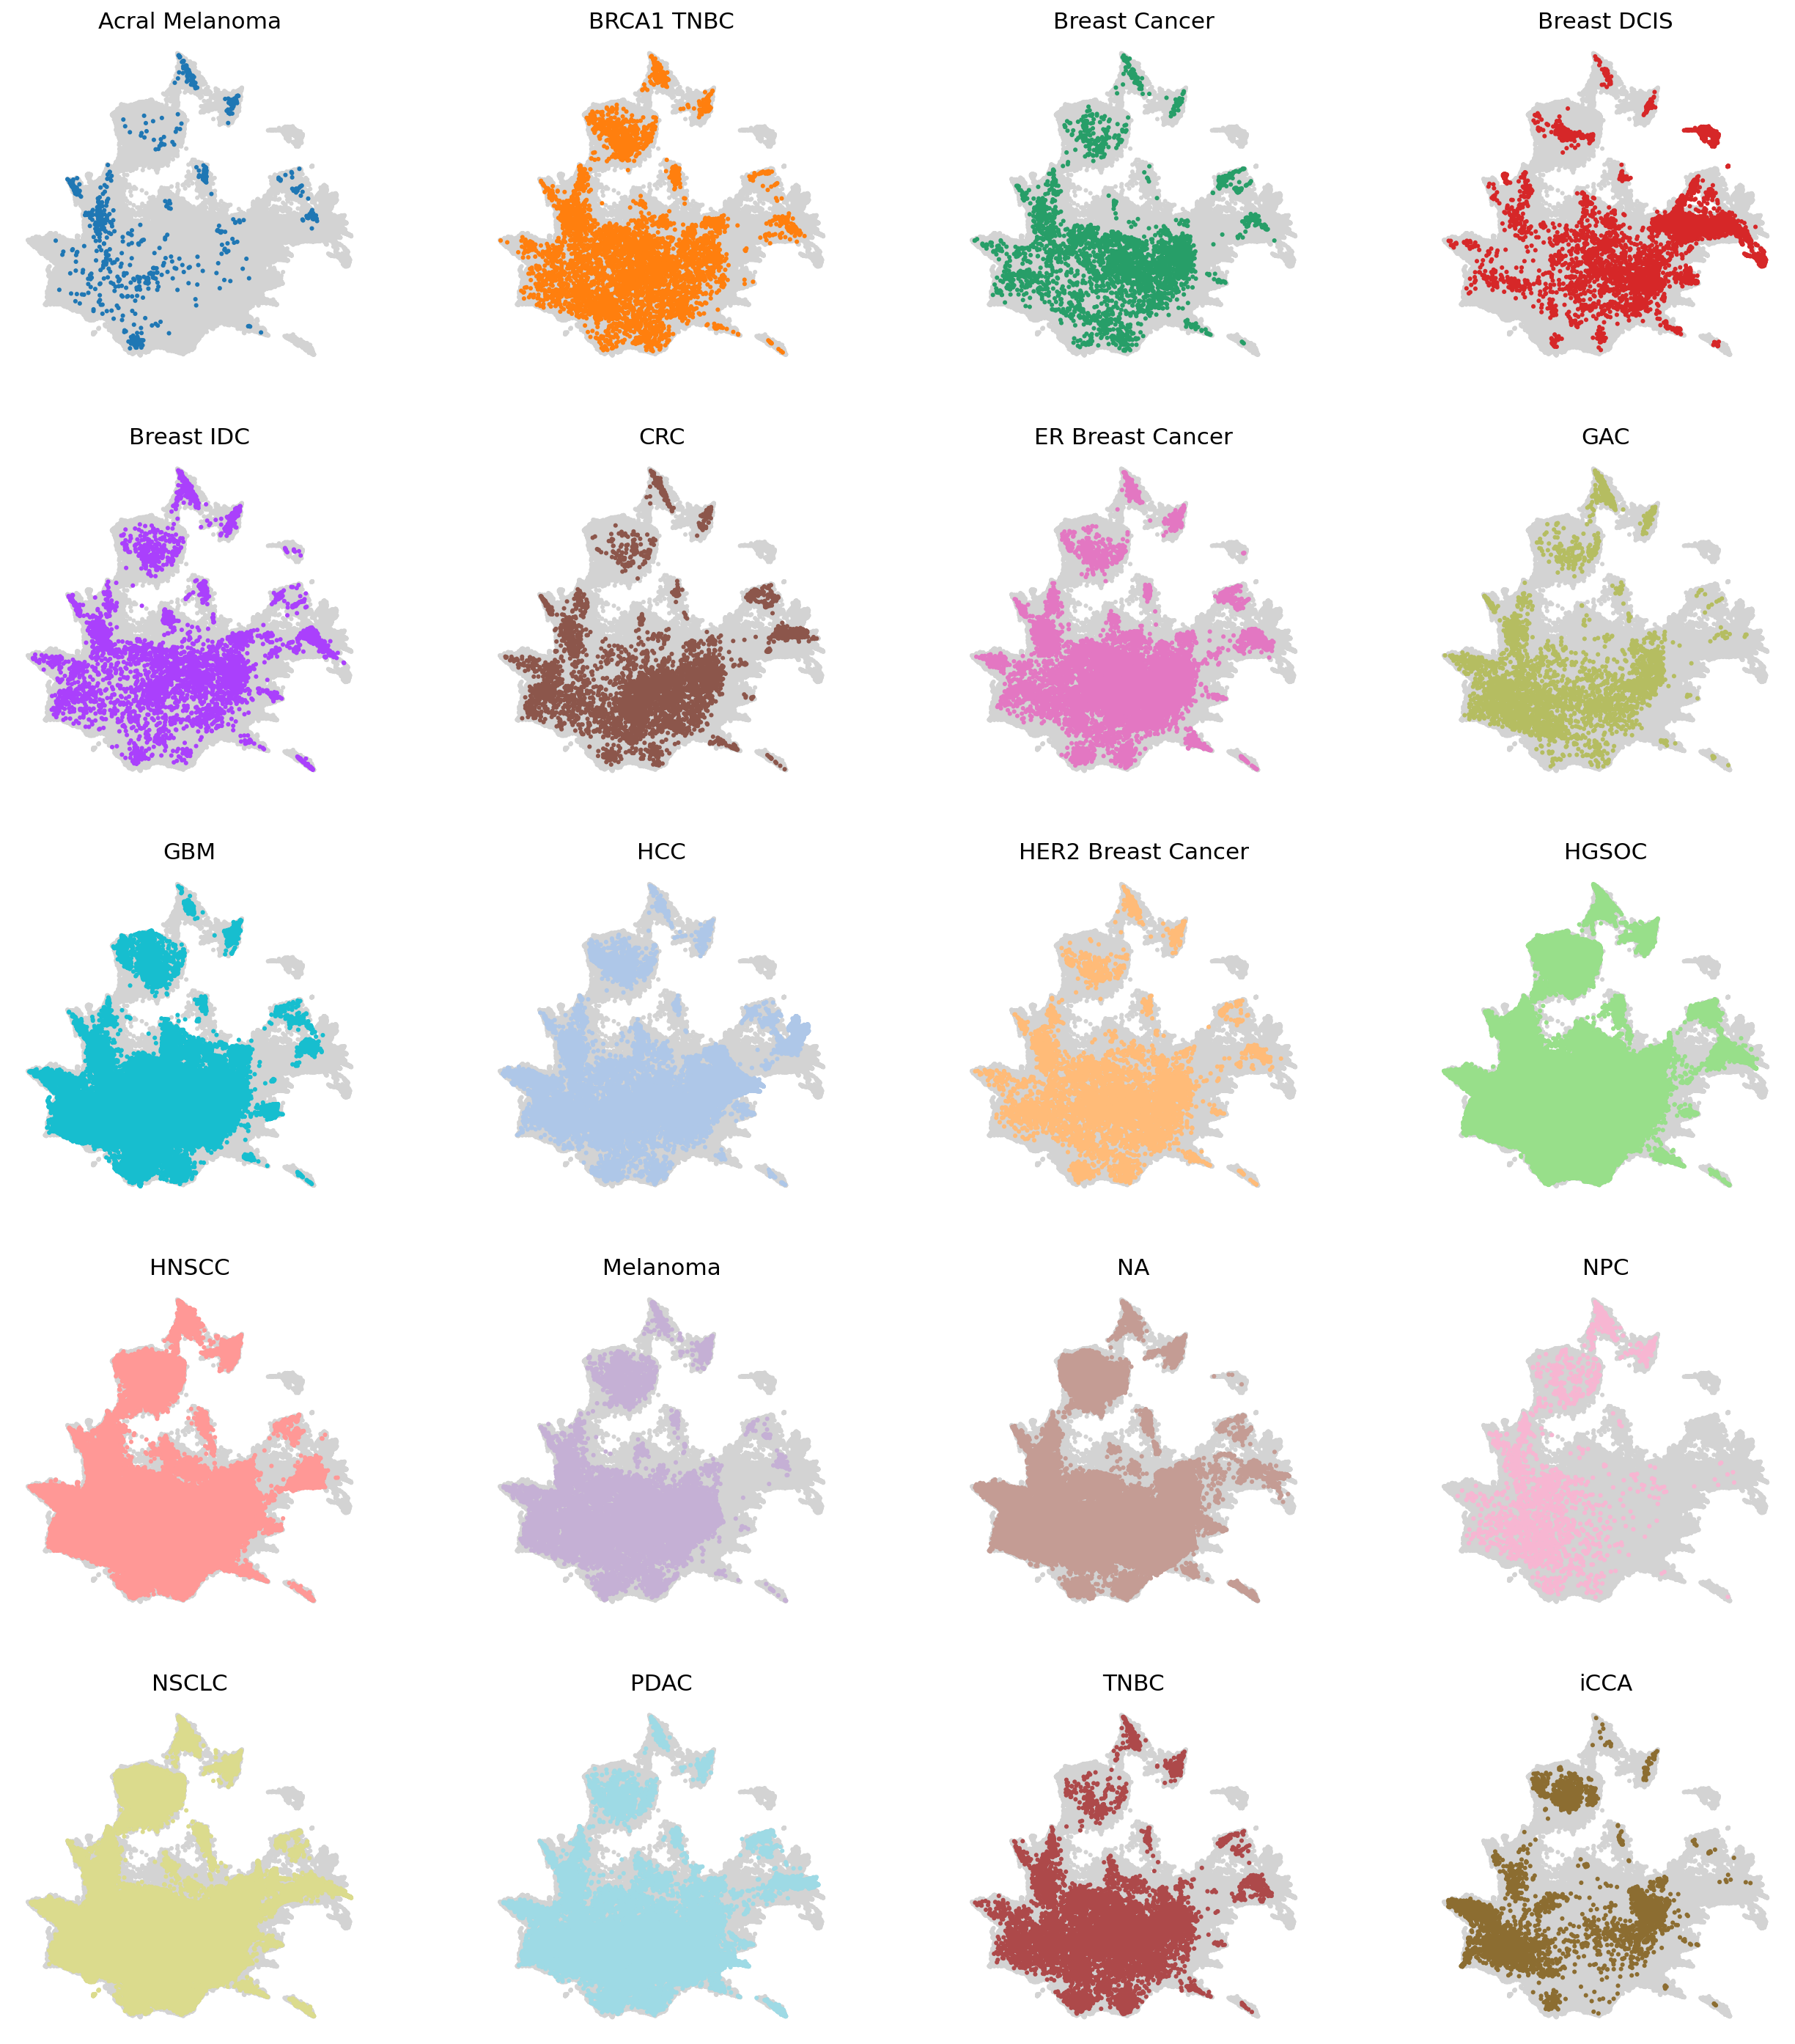

In [16]:
cluster_small_multiples(data, "cancer_subtype")

In [17]:
data

AnnData object with n_obs × n_vars = 623908 × 1634
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'sample_type_major_colors', 'cancer_subtype_colors', 'dataset_id_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [18]:
#export out this object to use for next analysis (clustering and annotating clusters)
data.write_h5ad("NRdata_to-cluster.h5ad", compression="gzip")

### This object is now ready for clustering and annotating of clusters, see relevant notebook